This example demonstrates how to use the different algorithms to calculate the boost factor for a single disk configuration.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Julia-Init" data-toc-modified-id="Julia-Init-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Julia Init</a></span></li></ul></li><li><span><a href="#Recursive-Fourier-Propagation-(Cheerleader)" data-toc-modified-id="Recursive-Fourier-Propagation-(Cheerleader)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recursive Fourier Propagation (Cheerleader)</a></span><ul class="toc-item"><li><span><a href="#Initialize" data-toc-modified-id="Initialize-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Recursive-Fourier-Propagation-(Dancer)" data-toc-modified-id="Recursive-Fourier-Propagation-(Dancer)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recursive Fourier Propagation (Dancer)</a></span><ul class="toc-item"><li><span><a href="#Initialize" data-toc-modified-id="Initialize-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Mode-Matching-(Transformer)" data-toc-modified-id="Mode-Matching-(Transformer)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Mode Matching (Transformer)</a></span><ul class="toc-item"><li><span><a href="#Initialize" data-toc-modified-id="Initialize-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initialize</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Dancer-vs.-Cheerleader" data-toc-modified-id="Dancer-vs.-Cheerleader-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dancer vs. Cheerleader</a></span></li><li><span><a href="#Cheerleader-vs.-Modes" data-toc-modified-id="Cheerleader-vs.-Modes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cheerleader vs. Modes</a></span></li></ul></li><li><span><a href="#Outlook" data-toc-modified-id="Outlook-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Outlook</a></span></li></ul></div>

### Julia Init

In [1]:
#Parallelization
using Distributed

In [2]:
# If you installed BoostFractor
@everywhere begin
    using BoostFractor
end

In [2]:
# If you just downloaded the githup repository and do not want to install the package
@everywhere begin
    push!(LOAD_PATH, "../src");
    using BoostFractor;
end

In [3]:
#Plotting
using PyPlot

## Recursive Fourier Propagation (Cheerleader)

### Initialize

In [4]:
@everywhere begin
    # Initialize Coordinate System
    dx = 0.01
    coords = SeedCoordinateSystem(X = -0.5:dx:0.5, Y = -0.5:dx:0.5)
    
    diskR = 0.15
    
    # SetupBoundaries
    # No Tilt or surface roughness here.
    epsilon = 9
    eps = Array{Complex{Float64}}([NaN,1,epsilon,1])
    R = -(1 - sqrt(epsilon)) / (1 + sqrt(epsilon))
    r = Array{Complex{Float64}}([1.0, -R, R]);
    distance = [0.0, 0.15, 0.15/sqrt.(epsilon), 0.0]*1e-2
    
    sbdry = SeedSetupBoundaries(coords, diskno=1, distance=distance, reflectivities=r, epsilon=eps)
    
end

In [4]:
@everywhere begin
    
    # Coordinate System
    dx = 0.005
    X = -0.5:dx:0.5 #(for 1D use: "X = [1e-7]")
    Y = -0.5:dx:0.5
    
    diskR=0.15
    
    # SetupBoundaries (note that this expects the mirror to be defined explicitly as a region)
    sbdry = SeedSetupBoundaries(1)

    epsilon = 9
    sbdry.eps = Array{Complex{Float64}}([NaN, 1,epsilon,1])
    R = -(1 - sqrt(epsilon)) / (1 + sqrt(epsilon))
    sbdry.r = Array{Complex{Float64}}([1.0, -R, R]);
    sbdry.distance = [0.0, 0.15, 0.15/sqrt.(epsilon), 0.0]*1e-2
    sbdry.relative_tilt_x = zeros(4)
    sbdry.relative_tilt_y = zeros(4)
    sbdry.relative_surfaces = zeros(4,length(X), length(Y))
    
    # Initialize coordinate system    
    init_coords(X,Y)
end

### Run

In [5]:
# Let us sweep over different disk phase depths for a disk at distance lambda/2 infront of the mirror
# Of course the same way you can create a parallelized frequency sweep, etc.
@everywhere Deps = 0:0.1:3*pi
@everywhere zcat(args...) = cat(dims = 3, args...)
@time result = @sync @distributed (zcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi # One could optimize this for maximal boost in 1D before; its left out here for simplicitly and just set to pi
    print("Running dEps = $deps (dNu = $dnu)... \n")

    # Set the distances (the wavelength in free space is 30mm, in the medium 10mm (free space devided by sqrt(epsilon))
    sbdry.distance = [0.0,(dnu)*3e-2/(2*pi), (deps)*1e-2/(2*pi),0.e-3];

    nmax = 100 # Maximum Number of Iterations
    #1D (if you calculate in 1D, use (vcat) above instead of (zcat) )
    #cheerleader(0,nmax,sbdry; prop=propagator1D,f=10e9,Xset=X,Yset=Y)
    #3D    
    cheerleader(0,nmax,sbdry,coords; prop=propagator,f=10e9,diskR=diskR)
end;

boost_factor_cheerleader = sum(abs2.(result), dims=(1,2))[1,1,:]*dx*dx/(pi*diskR^2);

Running dEps = 0.0 (dNu = π)... 
Running dEps = 0.1 (dNu = π)... 
Running dEps = 0.2 (dNu = π)... 
Running dEps = 0.30000000000000004 (dNu = π)... 
Running dEps = 0.4 (dNu = π)... 
Running dEps = 0.5 (dNu = π)... 
Running dEps = 0.6000000000000001 (dNu = π)... 
Running dEps = 0.7000000000000001 (dNu = π)... 
Running dEps = 0.8 (dNu = π)... 
Running dEps = 0.9 (dNu = π)... 
Running dEps = 1.0 (dNu = π)... 
Running dEps = 1.1 (dNu = π)... 
Running dEps = 1.2000000000000002 (dNu = π)... 
Running dEps = 1.3 (dNu = π)... 
Running dEps = 1.4000000000000001 (dNu = π)... 
Running dEps = 1.5 (dNu = π)... 
Running dEps = 1.6 (dNu = π)... 
Running dEps = 1.7000000000000002 (dNu = π)... 
Running dEps = 1.8 (dNu = π)... 
Running dEps = 1.9000000000000001 (dNu = π)... 
Running dEps = 2.0 (dNu = π)... 
Running dEps = 2.1 (dNu = π)... 
Running dEps = 2.2 (dNu = π)... 
Running dEps = 2.3000000000000003 (dNu = π)... 
Running dEps = 2.4000000000000004 (dNu = π)... 
Running dEps = 2.5 (dNu = π)... 
Runnin

In [5]:
# Let us sweep over different disk phase depths for a disk at distance lambda/2 infront of the mirror
# Of course the same way you can create a parallelized frequency sweep, etc.
@everywhere Deps = 0:0.05:3*pi
@everywhere zcat(args...) = cat(dims = 3, args...)
@time result = @sync @distributed (zcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi # One could optimize this for maximal boost in 1D before; its left out here for simplicitly and just set to pi
    print("Running dEps = $deps (dNu = $dnu)... \n")

    # Set the distances (the wavelength in free space is 30mm, in the medium 10mm (free space devided by sqrt(epsilon))
    sbdry.distance = [0.0, (dnu)*3e-2/(2*pi), (deps)*1e-2/(2*pi),0.e-3];

    nmax = 100 # Maximum Number of Iterations
    #1D (if you calculate in 1D, use (vcat) above instead of (zcat) )
    #cheerleader(0,nmax,sbdry; prop=propagator1D,f=10e9,Xset=X,Yset=Y)
    #3D    
    cheerleader(0,nmax,sbdry; prop=propagator,f=10e9,Xset=X,Yset=Y,diskR=diskR)
end;

boost_factor_cheerleader = sum(abs2.(result), dims=(1,2))[1,1,:]*dx*dx/(pi*diskR^2);

 56.468652 seconds (6.55 M allocations: 5.094 GiB, 1.71% gc time)


In [6]:
# The 1D Calculation for comparision:


@everywhere Deps = 0:0.1:3*pi
@everywhere zcat(args...) = cat(dims = 3, args...)
@time result1D = @sync @distributed (vcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi 
    
    sbdry.distance = [0.0, (dnu)*3e-2/(2*pi), deps*1e-2/(2*pi),0.0];
    coords1D = SeedCoordinateSystem(X = [1e-7], Y = [1e-7])

    nmax = 100 # Maximum Number of Iterations 
    cheerleader(0,nmax,sbdry,coords1D; prop=propagator1D,f=10e9)
end;

boost_factor_cheerleader_1d = abs2.(result1D);

  4.713145 seconds (4.94 M allocations: 6.155 GiB, 12.78% gc time)


In [6]:
# The 1D Calculation for comparision:


@everywhere Deps = 0:0.05:3*pi
@everywhere zcat(args...) = cat(dims = 3, args...)
@time result1D = @sync @distributed (vcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi 
    
    sbdry.distance = [0, (dnu)*3e-2/(2*pi), deps*1e-2/(2*pi),0];

    nmax = 100 # Maximum Number of Iterations 
    cheerleader(0,nmax,sbdry; prop=propagator1D,f=10e9,Xset=[1e-7],Yset=[1e-7])
end;

boost_factor_cheerleader_1d = abs2.(result1D);

  7.279555 seconds (6.05 M allocations: 286.521 MiB, 2.44% gc time)


## Recursive Fourier Propagation (Dancer)

**This algorithm is depraced. Use `cheerleader` for double performance.**

### Initialize

In [7]:
@everywhere begin
    # Initialize Coordinate System
    dx = 0.01
    coords = SeedCoordinateSystem(X = -0.5:dx:0.5, Y = -0.5:dx:0.5)
    
    diskR = 0.15
    
    # SetupBoundaries
    # No Tilt or surface roughness here.
    epsilon = 9
    eps = Array{Complex{Float64}}([NaN,1,epsilon,1])
    R = -(1 - sqrt(epsilon)) / (1 + sqrt(epsilon))
    r = Array{Complex{Float64}}([1.0, -R, R]);
    distance = [0.0, 0.15, 0.15/sqrt.(epsilon), 0.0]*1e-2
    
    sbdry = SeedSetupBoundaries(coords, diskno=1, distance=distance, reflectivities=r, epsilon=eps)
    
end

In [7]:
@everywhere begin
    
    # Coordinate System
    dx = 0.005
    X = -0.5:dx:0.5 #(for 1D use: "X = [1e-7]")
    Y = -0.5:dx:0.5
    diskR=0.15
    
    # SetupBoundaries (note that this expects the mirror to be defined explicitly as a region)
    sbdry = SeedSetupBoundaries(1)

    epsilon = 9
    sbdry.eps = Array{Complex{Float64}}([1,epsilon,1])
    R = -(1 - sqrt(epsilon)) / (1 + sqrt(epsilon))
    sbdry.r = Array{Complex{Float64}}([1.0, -R, R, 0]);
    sbdry.distance = [0.15, 0.15/sqrt.(epsilon), 0.0]*1e-2
    sbdry.relative_tilt_x = zeros(3)
    sbdry.relative_tilt_y = zeros(3)
    sbdry.relative_surfaces = zeros(3,length(X), length(Y))
    
    # Initialize coordinate system    
    init_coords(X,Y)
end

### Run

In [8]:
# Let us sweep over different disk phase depths for a disk at distance lambda/2 infront of the mirror
# Of course the same way you can create a parallelized frequency sweep, etc.
@everywhere Deps = 0:0.1:3*pi
@everywhere zcat(args...) = cat(dims = 3, args...)
@time result_dancer = @sync @distributed (zcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi # One could optimize this for maximal boost in 1D before; its left out here for simplicitly and just set to pi
    print("Running dEps = $deps (dNu = $dnu)... \n")

    # Set the distances (the wavelength in free space is 30mm, in the medium 10mm (free space devided by sqrt(epsilon))
    sbdry.distance = [0.0, (dnu)*3e-2/(2*pi), Deps[i]*1e-2/(2*pi),0];

    nmax = 200 # Maximum Number of Iterations
    #1D (if you calculate in 1D, use (vcat) above instead of (zcat) )
    #dancer(0,nmax,sbdry; prop=propagator1D,f=10e9,Xset=[0.0000001],Yset=[0.0000001])
    #3D    
    dancer(0,nmax,sbdry,coords; prop=propagator,f=10e9,diskR=diskR)
end;

Running dEps = 0.0 (dNu = π)... 
Running dEps = 0.1 (dNu = π)... 
Running dEps = 0.2 (dNu = π)... 
Running dEps = 0.30000000000000004 (dNu = π)... 
Running dEps = 0.4 (dNu = π)... 
Running dEps = 0.5 (dNu = π)... 
Running dEps = 0.6000000000000001 (dNu = π)... 
Running dEps = 0.7000000000000001 (dNu = π)... 
Running dEps = 0.8 (dNu = π)... 
Running dEps = 0.9 (dNu = π)... 
Running dEps = 1.0 (dNu = π)... 
Running dEps = 1.1 (dNu = π)... 
Running dEps = 1.2000000000000002 (dNu = π)... 
Running dEps = 1.3 (dNu = π)... 
Running dEps = 1.4000000000000001 (dNu = π)... 
Running dEps = 1.5 (dNu = π)... 
Running dEps = 1.6 (dNu = π)... 
Running dEps = 1.7000000000000002 (dNu = π)... 
Running dEps = 1.8 (dNu = π)... 
Running dEps = 1.9000000000000001 (dNu = π)... 
Running dEps = 2.0 (dNu = π)... 
Running dEps = 2.1 (dNu = π)... 
Running dEps = 2.2 (dNu = π)... 
Running dEps = 2.3000000000000003 (dNu = π)... 
Running dEps = 2.4000000000000004 (dNu = π)... 
Running dEps = 2.5 (dNu = π)... 
Runnin

In [8]:
# Let us sweep over different disk phase depths for a disk at distance lambda/2 infront of the mirror
# Of course the same way you can create a parallelized frequency sweep, etc.
@everywhere Deps = 0:0.05:3*pi
@everywhere zcat(args...) = cat(dims = 3, args...)
@time result_dancer = @sync @distributed (zcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi # One could optimize this for maximal boost in 1D before; its left out here for simplicitly and just set to pi
    print("Running dEps = $deps (dNu = $dnu)... \n")

    # Set the distances (the wavelength in free space is 30mm, in the medium 10mm (free space devided by sqrt(epsilon))
    sbdry.distance = [(dnu)*3e-2/(2*pi), Deps[i]*1e-2/(2*pi),0];

    nmax = 200 # Maximum Number of Iterations
    #1D (if you calculate in 1D, use (vcat) above instead of (zcat) )
    #dancer(0,nmax,sbdry; prop=propagator1D,f=10e9,Xset=[0.0000001],Yset=[0.0000001])
    #3D    
    dancer(0,nmax,sbdry; prop=propagator,f=10e9,Xset=X,Yset=Y,diskR=diskR)
end;

119.026099 seconds (1.94 M allocations: 4.739 GiB, 0.41% gc time)


In [9]:
boost_factor_dancer = sum(abs2.(result_dancer), dims=(1,2))[1,1,:]*dx*dx/(pi*diskR^2);

## Mode Matching (Transformer)

### Initialize

In [10]:
@everywhere begin
    # Initialize Coordinate System
    dx = 0.01
    coords = SeedCoordinateSystem(X = -0.5:dx:0.5, Y = -0.5:dx:0.5)
    
    diskR = 0.15
    
    # SetupBoundaries
    # No Tilt or surface roughness here.
    epsilon = 9
    eps = Array{Complex{Float64}}([NaN,1,epsilon,1])
    R = -(1 - sqrt(epsilon)) / (1 + sqrt(epsilon))
    r = Array{Complex{Float64}}([1.0, -R, R]);
    distance = [0.0, 0.15, 0.15/sqrt.(epsilon), 0.0]*1e-2
    
    sbdry = SeedSetupBoundaries(coords, diskno=1, distance=distance, reflectivities=r, epsilon=eps)
    
    # Initialize modes
    Mmax = 10
    Lmax = 0 # l-Modes are irrelevant for the azimuthally symmetric haloscope
    # For a 1D calculation:
    #wvgmodes = SeedWaveguidemodes(coords, ThreeDim=false, Mmax=Mmax, Lmax=Lmax, diskR=diskR)
    # For 3D:
    wvgmodes = SeedWaveguidemodes(coords, ThreeDim=true, Mmax=Mmax, Lmax=Lmax, diskR=diskR)
    
end

In [27]:
@everywhere begin
    
    # Coordinate System
    dx = 0.005
    X = -0.5:dx:0.5 #(for 1D use: "X = [1e-7]")
    Y = -0.5:dx:0.5
    diskR=0.15
    
    # SetupBoundaries (note that this expects the mirror to be defined explicitly as a region)
    sbdry = SeedSetupBoundaries(1)

    epsilon = 9
    sbdry.eps = Array{Complex{Float64}}([1e20, 1,epsilon,1])
    # Reflectivities do not need to be set.
    sbdry.distance = [0.0, 0.15, 0.15/sqrt.(epsilon), 0.0]*1e-2
    sbdry.relative_tilt_x = zeros(4)
    sbdry.relative_tilt_y = zeros(4)
    sbdry.relative_surfaces = zeros(4,length(X), length(Y))
    
    # Initialize coordinate system    
    init_coords(X,Y)
    
    # Initialize modes
    Mmax = 10
    Lmax = 0 # l-Modes are irrelevant for the azimuthally symmetric haloscope
    # For a 1D calculation:
    #init_modes_1d()
    # For 3D:
    init_waveguidemodes_3d(Mmax,Lmax;diskR=diskR)
    
end

### Run

In [11]:
# Let us sweep over different disk phase depths for a disk at distance lambda/2 infront of the mirror
# Of course the same way you can create a parallelized frequency sweep, etc.
@everywhere Deps = 0:0.1:3*pi
@time result_transformer = @sync @distributed (hcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi # One could optimize this for maximal boost in 1D before; its left out here for simplicitly and just set to pi
    print("Running dEps = $deps (dNu = $dnu)... \n")

    # Set the distances (the wavelength in free space is 30mm, in the medium 10mm (free space devided by sqrt(epsilon))
    sbdry.distance = [0.0, (dnu)*3e-2/(2*pi), Deps[i]*1e-2/(2*pi),0];

    #1D (if you calculate in 1D, use (vcat) above instead of (hcat) )
    #transformer(sbdry; prop=propagator1D,f=10e9,Xset=[1e-7],Yset=[1e-7])
    #3D    
    transformer(sbdry,coords,wvgmodes; prop=propagator,f=10e9,diskR=diskR)
end;

boost_factor_transformer = sum(abs2.(result_transformer), dims=1)[1,:];

Running dEps = 0.0 (dNu = π)... 
Running dEps = 0.1 (dNu = π)... 
Running dEps = 0.2 (dNu = π)... 
Running dEps = 0.30000000000000004 (dNu = π)... 
Running dEps = 0.4 (dNu = π)... 
Running dEps = 0.5 (dNu = π)... 
Running dEps = 0.6000000000000001 (dNu = π)... 
Running dEps = 0.7000000000000001 (dNu = π)... 
Running dEps = 0.8 (dNu = π)... 
Running dEps = 0.9 (dNu = π)... 
Running dEps = 1.0 (dNu = π)... 
Running dEps = 1.1 (dNu = π)... 
Running dEps = 1.2000000000000002 (dNu = π)... 
Running dEps = 1.3 (dNu = π)... 
Running dEps = 1.4000000000000001 (dNu = π)... 
Running dEps = 1.5 (dNu = π)... 
Running dEps = 1.6 (dNu = π)... 
Running dEps = 1.7000000000000002 (dNu = π)... 
Running dEps = 1.8 (dNu = π)... 
Running dEps = 1.9000000000000001 (dNu = π)... 
Running dEps = 2.0 (dNu = π)... 
Running dEps = 2.1 (dNu = π)... 
Running dEps = 2.2 (dNu = π)... 
Running dEps = 2.3000000000000003 (dNu = π)... 
Running dEps = 2.4000000000000004 (dNu = π)... 
Running dEps = 2.5 (dNu = π)... 
Runnin

In [28]:
# Let us sweep over different disk phase depths for a disk at distance lambda/2 infront of the mirror
# Of course the same way you can create a parallelized frequency sweep, etc.
@everywhere Deps = 0:0.05:3*pi
@time result_transformer = @sync @distributed (hcat) for i in 1:length(Deps)
    deps = Deps[i]
    dnu = pi # One could optimize this for maximal boost in 1D before; its left out here for simplicitly and just set to pi
    print("Running dEps = $deps (dNu = $dnu)... \n")

    # Set the distances (the wavelength in free space is 30mm, in the medium 10mm (free space devided by sqrt(epsilon))
    sbdry.distance = [0.0, (dnu)*3e-2/(2*pi), Deps[i]*1e-2/(2*pi),0];

    #1D (if you calculate in 1D, use (vcat) above instead of (hcat) )
    #transformer(sbdry; prop=propagator1D,f=10e9,Xset=[1e-7],Yset=[1e-7])
    #3D    
    transformer(sbdry; prop=propagator,f=10e9,Xset=X,Yset=Y,diskR=diskR)
end;

boost_factor_transformer = sum(abs2.(result_transformer), dims=1)[1,:];

  4.924991 seconds (101.34 k allocations: 5.741 MiB)


In [17]:
print(boost_factor_cheerleader_1d)

[1.0000000000000016; 1.0203054734322083; 1.078473498271482; 1.180269530691867; 1.3362145017990872; 1.5634232731987106; 1.8888009911035124; 2.3544645840357146; 3.026892616664837; 4.012231509023658; 5.480928617183593; 7.702396407715537; 11.071572134568159; 16.031564905252957; 22.604624952735765; 29.292724136057807; 32.875750689842675; 31.650611532768917; 27.48034685152232; 22.871586677813475; 18.97479854296502; 15.973979210343186; 13.72847499068628; 12.054282436736285; 10.800376872930865; 9.856763062818349; 9.146392569696753; 8.61597346295468; 8.228892968917956; 7.960340082855485; 7.794109161345509; 7.720599049862919; 7.73567107186968; 7.840168392166354; 8.040013329645749; 8.34689950595655; 8.77969894127185; 9.366826193803782; 10.149948593943709; 11.1895655769517; 12.57289132692404; 14.423341203604975; 16.90588166697649; 20.20465282491442; 24.397367006245155; 29.05796209480991; 32.546709478069445; 32.18701524733261; 27.177868921279728; 20.22233931625758; 14.136133104056455; 9.76105257796

## Results

### Dancer vs. Cheerleader

The time for one iteration for both algorithms should be roughly comparable. For this simple case, a iteration in `cheerleader` seems to be still slightly faster, though. Therefore, here, `cheerleader` is a factor ~2 faster.

`cheerleader` with `nmax = 100` should lead roughly the same result than `dancer` with `nmax = 200`. 

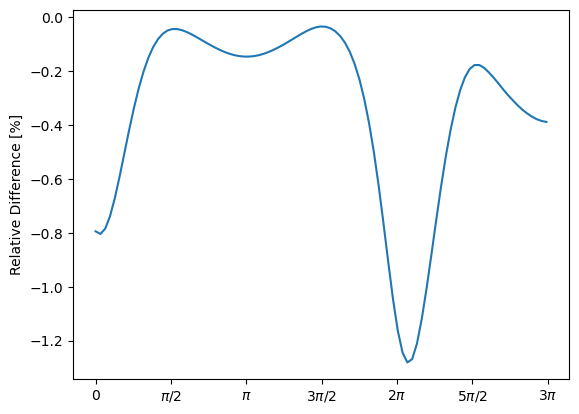

In [12]:
plot(Deps, 100*(boost_factor_dancer.-boost_factor_cheerleader)./
           (0.5 .*(boost_factor_dancer.+boost_factor_cheerleader)))
ylabel("Relative Difference [%]")
xticks([0,pi/2,pi,3pi/2,2pi,2.5pi, 3pi], ["0", "\$\\pi/2\$", "\$\\pi\$", "\$3\\pi/2\$", "\$2\\pi\$", "\$5\\pi/2\$", "\$3\\pi\$"]);

### Cheerleader vs. Modes

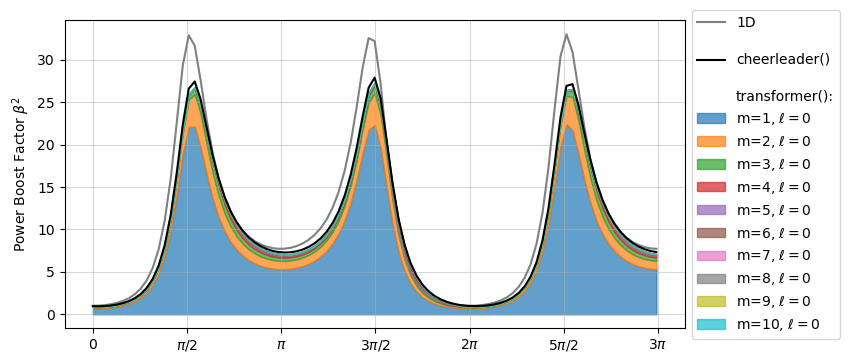

PyObject <matplotlib.legend.Legend object at 0x7fe854bc3310>

In [13]:
figure(figsize=(8,4))




plot(Deps, boost_factor_cheerleader_1d, c="gray", label="1D")

plot(Deps, boost_factor_cheerleader, c="k", label="\ncheerleader()\n")



plot([], [], linewidth=0, label="transformer():")
#plot(Deps, boost_factor_transformer)
# Total power of modes iterated over / plotted so far
tot = zeros(length(result_transformer[1,:]))
# Iterate over modes
for i in 1:(wvgmodes.M*(wvgmodes.L*2+1))
    # get (m,l) indices
    m = Int( floor((i-1)/(wvgmodes.L*2+1))+1 )
    l = (i-1)%(wvgmodes.L*2+1)-wvgmodes.L
    # create label
    labeling = (l > 0 ? "m=$m, \$\\ell=\\pm\$$l" : l == 0 ? "m=$m, \$\\ell=0\$" : nothing)
    
    # do the plotting
    fill_between(Deps,tot, tot.+abs2.(result_transformer[i,:]), alpha=0.7/(1+abs(l)), label=labeling, color="C$(m-1)")
    
    # update total power
    tot .+= abs2.(result_transformer[i,:])
end

xticks([0,pi/2,pi,3pi/2,2pi,2.5pi, 3pi], ["0", "\$\\pi/2\$", "\$\\pi\$", "\$3\\pi/2\$", "\$2\\pi\$", "\$5\\pi/2\$", "\$3\\pi\$"])
ylabel("Power Boost Factor \$\\beta^2\$")
grid(alpha=0.5)

legend(loc="center left", bbox_to_anchor=(1.0,0.5))

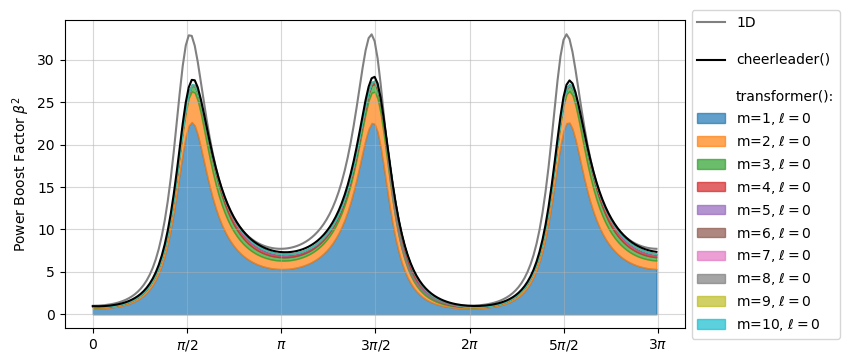

PyObject <matplotlib.legend.Legend object at 0x7f0323e84240>

In [30]:
figure(figsize=(8,4))




plot(Deps, boost_factor_cheerleader_1d, c="gray", label="1D")

plot(Deps, boost_factor_cheerleader, c="k", label="\ncheerleader()\n")



plot([], [], linewidth=0, label="transformer():")
#plot(Deps, boost_factor_transformer)
# Total power of modes iterated over / plotted so far
tot = zeros(length(result_transformer[1,:]))
# Iterate over modes
for i in 1:(BoostFractor.M*(BoostFractor.L*2+1))
    # get (m,l) indices
    m = Int( floor((i-1)/(BoostFractor.L*2+1))+1 )
    l = (i-1)%(BoostFractor.L*2+1)-BoostFractor.L
    # create label
    labeling = (l > 0 ? "m=$m, \$\\ell=\\pm\$$l" : l == 0 ? "m=$m, \$\\ell=0\$" : nothing)
    
    # do the plotting
    fill_between(Deps,tot, tot.+abs2.(result_transformer[i,:]), alpha=0.7/(1+abs(l)), label=labeling, color="C$(m-1)")
    
    # update total power
    tot .+= abs2.(result_transformer[i,:])
end

xticks([0,pi/2,pi,3pi/2,2pi,2.5pi, 3pi], ["0", "\$\\pi/2\$", "\$\\pi\$", "\$3\\pi/2\$", "\$2\\pi\$", "\$5\\pi/2\$", "\$3\\pi\$"])
ylabel("Power Boost Factor \$\\beta^2\$")
grid(alpha=0.5)

legend(loc="center left", bbox_to_anchor=(1.0,0.5))

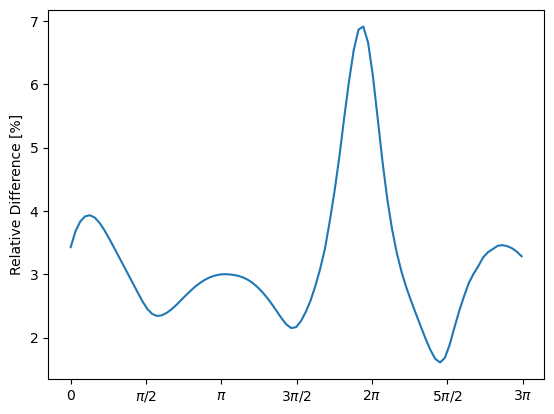

In [14]:
plot(Deps, abs.(100*(boost_factor_transformer.-boost_factor_cheerleader)./
           (0.5 .*(boost_factor_transformer.+boost_factor_cheerleader))))
ylabel("Relative Difference [%]")
xticks([0,pi/2,pi,3pi/2,2pi,2.5pi, 3pi], ["0", "\$\\pi/2\$", "\$\\pi\$", "\$3\\pi/2\$", "\$2\\pi\$", "\$5\\pi/2\$", "\$3\\pi\$"]);

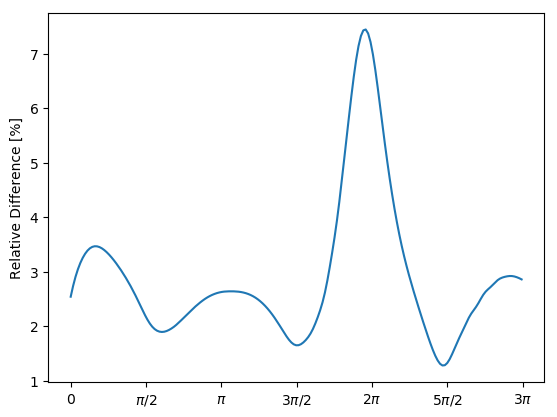

In [31]:
plot(Deps, abs.(100*(boost_factor_transformer.-boost_factor_cheerleader)./
           (0.5 .*(boost_factor_transformer.+boost_factor_cheerleader))))
ylabel("Relative Difference [%]")
xticks([0,pi/2,pi,3pi/2,2pi,2.5pi, 3pi], ["0", "\$\\pi/2\$", "\$\\pi\$", "\$3\\pi/2\$", "\$2\\pi\$", "\$5\\pi/2\$", "\$3\\pi\$"]);

Some Interpretation: Notice that the difference is small around the most resonant configurations ($\pi$, $3\pi/2$, $5\pi/2$, ...) and large near transparent configurations (multiples of $\pi$). This is because than more resonant the system gets, than more it acts like a "mode selector" such that higher modes are not resonantly enhanced. If you plot the relative power contained in the modes, you will find, that in the transparent cases the higher modes contain more relative power than in the resonant cases (try yourself ;-) )

## Outlook
In our paper (arXiv: https://arxiv.org/abs/1906.02677) we considered a optimized vacuum gap rather than a fixed gap. The following code can be used to optimize the gap such that the boost factor is maximized for a fixed disk thickness:

In [ ]:
@everywhere function boostfactor(dnu,deps;n=3)
    return abs2.((1. .- (1. .- 1. /n.^2)*( cos.(dnu)*(1 .- cos.(deps)) .+ n*sin.(deps)*sin.(dnu) )) /
           (exp.(-1im*dnu) * cos.(deps) .- sin.(deps)*((1im ./n) * cos.(dnu) .+ n * sin.(dnu) ) ))
end

In [ ]:
@everywhere using Optim
@everywhere function OptimDnu(deps;n=3)
    disk_phase_depth = deps
    function to_optimize(phase_depth)
        return -boostfactor(phase_depth, disk_phase_depth,n=n)
    end
    return Optim.minimizer(Optim.optimize(to_optimize, pi/2, 3*pi/2))
end